## Leaky binary models

#### Requirements
* Neuron values are either 0 or 1 (binary). The inputs and outputs for sure, and internally as much as possible.
* Weights are real values, which are maybe bounded. 

#### Modified Heaviside

The Heaviside function is defined as 
$$
H(x):=\begin{cases}1 \quad x\geq 0\\0 \quad x< 0.\end{cases}
$$
Mathematically, it has vanishing differential, because $H$ is essentially constant. 

<!-- We will use the following leaky variant of $H$, which depends on a non-negative constant $Q$:
$$
H(x, Q):= \begin{cases} 1 \quad x\geq 0\\ Q \quad x< 0.\end{cases}
$$ -->
For our purpose, it will be convenient to use the following differential for $H$, 
$$
H_{\text{backward}} := \begin{cases} 1 \quad x\geq 0\\ -1 \quad x< 0.\end{cases}
$$


#### Internal binary representation

In order to use classical float based layers for binary computations, we will use a leaky variant of a binary tensor. Instead of $[1, 0, 0, 1]$ we will use $[1, Q, Q, 1]$, where $Q<1$ is a non-negative constant, which is typically small. This will help to overcome a stop of the learning process, when too many neurons are inert, that is, do not propagate any signals.

The inputs and outputs will be binary. The function `binary_in` will turn all zeros into $Q$. The differential of `binary_in` is non-trivial, it is $=1$ on a $1$, and $=-1$ on a $0$, and then followed by a $\text{ReLU}$. As an example:
$$
\text{binary{\_}in}_{\text{backward at} [1, 0, 0, 1]}([y_0, y_1, y_2, y_3]) = \text{ReLU}([y_0, -y_1, -y_2, y_3]). 
$$
Is the $\text{ReLU}$ a choice or required?

#### Wrapping a float layer or model

Let $L$ be a classical layer, model, or autograd function. We can wrap transform it to $L\rightarrow L_{b}$ by composing with $H$ and $\text{binary{\_}in}$:
$$
L_{b} := H \circ L \circ \text{binary{\_}in}. 
$$
This is not very intuitive, need an example here.

Open points:
* The initialization of parameters will likely be different.

#### Heuristic of the learning algorithm

Let us consider the simplest case $y=L(x, w)$, in other words $x \xrightarrow{L} y$, where $x, y$ are $1$-dimensional tensors. We will assume that $L$ has a backward pass given by differential analysis.

We would like to understand the forward and backward pass of $L_b$:
$$
x \xrightarrow{L_b} y, \quad gy \xrightarrow{L_{b, \text{backward at\,} x}} gx, gw.
$$
Now, $x$ and $y$ are binary and have values in $\{0, 1\}$. The gradients $gx, gy$ will be non-negative floats (thanks to the `ReLU` in `binary_in`), but let's ignore this. The gradient $gw$ will consist of floats. 

The significance of $gy$ is given by the following. Whenever $gy$ is positive, the behavior of $y$ should change: if it was $0$ then it should become $1$ and vice versa. The more positive $gy$ is, the more urgent it is for $y$ to change. If $gy$ is negative, then the behavior should stay the same.

We compute
$$
gw = \text{sign}(y-0.5) \cdot gy\cdot  L_{\text{$w$-backward at\,} \text{binary{\_}in}(x)}(1),
$$
where $\text{sign}(y-0.5)$ is $=1$ if $y=1$ and $-1$ otherwise, it comes from the backward pass of the Heaviside. 

A modification $w - \epsilon \cdot gw$ would lead to 
$$
L(\text{binary{\_}in}(x), w- \epsilon \cdot gw) = L(\text{binary{\_}in}(x), w) - \epsilon \cdot \text{sign}(y-0.5) \cdot gy \cdot   (v, v),  
$$
where $v=L_{w-\text{backward at\,} \text{binary{\_}in}(x)}(1)$, and ignoring $\epsilon^2$. If $y=1$ this is trying to change the value of $L$ according to the sign of $-gy$. If $y=0$, it is trying to change the value of $L$ according to the sign of $gy$. That's the desired behavior.

Frequently, we will have an $L$, where $L_{w-\text{backward at\,} x}(1)=0$ if $x=0$. For example, that's the case if $L$ is linear. Therefore we use `binary_in` and get $L_{w-\text{backward at\,} \text{binary{\_}in}(x)}(1)\neq 0$ in most cases.

Let's consider $gx$. We compute
$$
gx = \text{sign}(y-0.5)\cdot \text{sign}(x-0.5) \cdot gy\cdot L_{x-\text{backward at\,} x}(1).
$$
A modification $x - \epsilon \cdot gx$ doesn't really make sense for two reasons:
* $x$ is binary
* From the previous part, we know that the value of $x$ will change according to $-\text{sign}(x-0.5) \cdot gx$.

For the first point, let's imagine $x=H(x')$. Then, by the second point, we should imagine a modification $x'- \epsilon\cdot \text{sign}(x') \cdot gx\cdot (\text{some non-negative value})$. This can only make a difference when $x'$ is very close to $0$ and $gx>0$.
Therefore, we have  
$$
\text{binary{\_}in}(x_{\text{modified}}) = \begin{cases} x + (1-Q)\cdot (-1)\cdot \text{sign}(x')  &\text{if modified} \\ x &\text{if no modification occurs.} \end{cases}
$$  
In case a proper modification occurs, we compute
$$
\begin{aligned}
L(\text{binary{\_}in}(x_{\text{modified}}), w) = L(\text{binary{\_}in}(x), w)  &+  (1-Q)\cdot (-1)\cdot \text{sign}(x-0.5) \cdot  L_{x-\text{backward at\,} x}(1) \\ &+ (\text{higher order terms}).
\end{aligned}
$$
At this point we have to make a simplification. The higher order terms cannot be controlled if we have higher derivatives for $L$ in $x$. That is, the backward pass $L_{x-\text{backward at\,} x}$ must have vanishing $x$-derivative. This is a heavy restriction.

Then 
$$
(1-Q)\cdot (-1)\cdot \text{sign}(x-0.5) \cdot  L_{x-\text{backward at\,} x}(1) = (1-Q)\cdot (-1) \cdot \text{sign}(y-0.5) \cdot \frac{gx}{gy},
$$
where $gy\neq 0$ and $gx>0$, because otherwise no modification. This shows that $L(\text{binary{\_}in}(x_{\text{modified}}), w)$ is modified (if at all) according to the sign: $-\text{sign}(y-0.5)\cdot gy$, which is the desired behavior.  

TODO: Arbitrary dimension for $x, y$.

### Linear model overview (old) 

Old approach, included for reference

#### Assumptions
* Fixed bias to fix ideas (subject to change).

#### Architecture
Let $H(x)$ be the binary step function 
$$
H(x):=\begin{cases}1 \quad x\geq 0\\0 \quad x< 0.\end{cases}
$$

The *forward pass* of one layer reads 
$$
L_i(x,w) := H\left( \sum_{j}  w[i,j]\cdot x[j] - B \right),
$$
where $x$ are the inputs, or neuron values, and $w$ are the weights, that is the synaptic values. We denote by $B$ the bias, it is a positive constant.

From inputs to final outputs with $n$ layers, the forward pass looks like 
$$
x_0 \xrightarrow{w_0} x_1 \xrightarrow{w_1} x_2 \rightarrow \dots \rightarrow x_{n-1} \xrightarrow{w_{n-1}} x_n,
$$
with 
$$
x_i = L(x_{i-1}, w_{i-1}), \quad x_0 = \text{given inputs}.
$$
Again, $x$ has only entries in $\{0, 1\}$, and $w$ has floats as entries (bounded?).  

The *backward pass* is given by
$$
gx_n \xrightarrow{gw_{n-1}} gx_{n-1} \xrightarrow{gw_{n-2}} gx_{n-2} \rightarrow \dots \rightarrow gx_{1} \xrightarrow{gw_{0}} gx_0,
$$
where 
\begin{split}
gx_i &= G(gx_{i+1}, x_{i+1}, x_{i}, w_{i})\\
gw_i &= W(gx_{i+1}, x_{i+1}, x_i) \\
gx_n &= Neq(\text{desired outputs}, x_n).
\end{split}
We will define $G$, $W$, and $Neq$ in the following. 

As for the forward pass, $gx$ has non-negative floats as entries, and $gw$ has floats as entries. Moreover, the shape of $x_i$ equals the shape of $gx_i$, and the shape of $w_i$ equals the shape of $gw_i$.

#### Backward pass formulas

##### Neq
For $x, y \in \{0, 1\}$, we set
$$
Neq(x, y) = \begin{cases} 0 \quad  &x=y, \\ 1 \quad &x\neq y. \end{cases} 
$$
This is generalized to $x$ and $y$ of the same shape by applying entry by entry. The signature is
```
Neq: (bool, shape) x (bool, shape) -> (bool, shape)  
```

##### W
Let $n$ be the shape of $x$ and $gx$, and let $m$ be the shape of $x'$. We define $W(gx, x, x')$, which is of shape $n\times m$, by 
$$
W(gx, x, x') := \left( -gx[i] \cdot P(x[i], x'[j]) \right)_{i,j},
$$
where 
$$
P(0, 1) = 1, \quad P(1, 1) = -1, \quad P(0, 0) = Q, \quad P(1, 0) = -Q,  
$$
with a non-negative $Q<1$. The value of $Q$ is connected to the learning rate (reference???). It is similar to a negative slope for a leaky ReLU. 

In order to compute $P$, we can use 
$$
P(x,y) =  (1 - 2 \cdot x) \cdot (Q  + (1 - Q) \cdot y) 
$$ 

The signature is
```
W: (bool, n) x (bool, n) x (bool, m) -> ({-1, -Q, 0, Q, 1}, n x m).  
```

##### G
Let $n$ be the shape of $x$ and $gx$, and $m$ the shape of $x'$, then $w'$ must have shape $n\times m$. We define 
$$
G(gx, x, x', w') = \left(ReLU\left( \sum_{i} gx[i]\cdot Seq(x[i], x'[j])  \cdot w[i,j] \right) \right)_{j},
$$
where 
$$
Seq(x,y) = (2x-1)\cdot (2y-1)  = \begin{cases} 1 \quad  &x=y, \\ -1 \quad &x\neq y. \end{cases}
$$
The signature is 
```
G: (bool, n) x (bool, n) x (bool, m) x (float, n x m) -> (non-negative, m).
```

#### Unsupervised methods

##### Oja's rule
(This doesn't seem to work well)

Setup: $x \xrightarrow{w} y$, we don't have a gradient for $y$ or $x$, but one for $w$:
$$
gw[i,j] := y[i]\cdot (y[i]\cdot w[i,j] - x[j]\cdot B). 
$$
(Or some other positive multiple of $B$.)

We have only non-zero gradients if $y[i]=1$. Additionally, we get a *positive* gradient if 
* $x[j]=1$ and $w[i,j]>B$, 
* or $x[j]=0$ and $w[i,j]>0$. 

We get a *negative* gradient if 
* $x[j]=1$ and $w[i,j]<B$, 
* or $x[j]=0$ and $w[i,j]<0$.

This implies two behaviours:
* If $x[j]$ is inert then the weight will converge to zero.
* The weight will be bounded by $B$ or some other positive multiple of $B$.

##### Generalized Hebbian algorithm

Setup: $x \xrightarrow{w} y$, we don't have a gradient for $y$ or $x$, but one for $w$:
$$
gw[i,j] := y[i]\cdot (- x[j]\cdot B + \sum_{k} y[k]\cdot w[k,j]). 
$$
(Or some other to be determined positive multiple of $B$.)

### Pytorch implementation

In [1]:
import torch

#### Heaviside and ReLU

In [2]:
input = torch.tensor([-1, 0, 1], dtype=torch.float32)
value = torch.tensor([1], dtype=torch.float32)

def H_forward(input):
    return torch.heaviside(input, value)

class HeavisideBN(torch.autograd.Function):
    @staticmethod
    # B and Q are added as tensors
    def forward(ctx, input):
        output = H_forward(input)
        #print("In forward: {}".format(output))
        ctx.save_for_backward(output)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        output, = ctx.saved_tensors

        grad_input  = None
        grad_input = grad_output * (2. * output - 1.)
    
        return grad_input

In [3]:
H = HeavisideBN.apply

In [4]:
H_forward(input)==H(input)

input.requires_grad = True

H(input).backward(torch.tensor([1., 1., 1.]))
input.grad

tensor([-1.,  1.,  1.])

#### binary_in

In [5]:
#ReLU = torch.nn.ReLU()
LReLU = torch.nn.LeakyReLU(negative_slope=0.5, inplace=False)

class BinaryIn(torch.autograd.Function):
    @staticmethod
    # B and Q are added as tensors
    def forward(ctx, input, Q):
        output = input + Q * (1.-input)
        #print("In forward: {}".format(output))
        ctx.save_for_backward(input)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors

        grad_input  = None
        grad_input = grad_output * (2. * input - 1.)
    
        return LReLU(grad_input), None

In [6]:
binary_in = BinaryIn.apply

In [7]:
input = torch.tensor([1, 0, 0, 1], dtype=torch.float32, requires_grad=True)

t = binary_in(input, torch.tensor([0.01]))
print(t)

t.backward(torch.tensor([1., 1., 1., 1.]))
input.grad

tensor([1.0000, 0.0100, 0.0100, 1.0000], grad_fn=<BinaryInBackward>)


tensor([ 1.0000, -0.5000, -0.5000,  1.0000])

#### Wrapping class

In [8]:
from platform import architecture


class BN(torch.nn.Module):

    def __init__(self, model, Q):
        super(BN, self).__init__()
        self.core = model
        self.Q = Q

    def forward(self, input):
        x = binary_in(input, self.Q)
        x = self.core(x)
        x = H(x)
        return x

def bn(arch, Q):
    def new(*args, **kwargs):
        model = arch(*args, **kwargs)
        return BN(model, Q)
    return new

In [9]:
t = bn(torch.nn.Linear, torch.tensor([0.05]))(2, 2)

In [10]:
t(torch.tensor([0.1, 2.]))

tensor([0., 0.], grad_fn=<HeavisideBNBackward>)

In [11]:
list(t.core.parameters())

[Parameter containing:
 tensor([[ 0.1065, -0.5896],
         [ 0.1417,  0.0650]], requires_grad=True),
 Parameter containing:
 tensor([ 0.2343, -0.3992], requires_grad=True)]

##### Linear model

We will start with constant bias.

TODO: 
* Fix scale parameter, it's unclear how to set a meaningful one. 
* Weight init does not work properly for large dimensions.

In [12]:
def weights_init(shape, scale, B):

    first = scale * torch.rand(shape, dtype=torch.float32, requires_grad=False)

    # make sure the rows sum up to B
    first += B * torch.tensor([1/shape[1]], dtype=torch.float32) 

    first.requires_grad = True
    return first

In [13]:
class LinearB(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super(LinearB, self).__init__()
        assert "Q" in kwargs, "Pass Q (leaky zero) as kwarg"
        assert "B" in kwargs, "Pass B (bias) as kwarg"
        Q = kwargs.pop("Q")
        B = kwargs.pop("B")
        self.main = bn(torch.nn.Linear, Q)(*args, **kwargs)
        self.core = self.main.core
        self.constant_bias(-B)
        self.re_init(B)
    
    def re_init(self, B):
        pass
        # TODO correct scale and initialization?
        # scale = 2*B
        # with torch.no_grad():
        #     self.core.weight = torch.nn.Parameter(weights_init((self.core.out_features, self.core.in_features), 
        #                                                         scale, B))
                                                                
    def constant_bias(self, B):
        self.core.bias.requires_grad = False
        with torch.no_grad():
            self.core.bias.fill_(B)

    def forward(self, input):
        return self.main(input)     

In [14]:
t = LinearB(2,2, Q=torch.tensor([0.05]), B=1.)

In [15]:
list(t.core.parameters())

[Parameter containing:
 tensor([[0.2269, 0.1877],
         [0.0917, 0.5701]], requires_grad=True),
 Parameter containing:
 tensor([-1., -1.])]

##### Convolution layer

We will start with constant bias.

TODO: 
* Weight init does not work properly for large dimensions.

In [16]:
class Conv2dBN(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super(Conv2dBN, self).__init__()
        assert "Q" in kwargs, "Pass Q (leaky zero) as kwarg"
        assert "B" in kwargs, "Pass B (bias) as kwarg"
        Q = kwargs.pop("Q")
        B = kwargs.pop("B")
        self.main = bn(torch.nn.Conv2d, Q)(*args, **kwargs)
        self.core = self.main.core
        self.constant_bias(-B)
        self.re_init(B)
    
    def re_init(self, B):
        pass
                                                                
    def constant_bias(self, B):
        self.core.bias.requires_grad = False
        with torch.no_grad():
            self.core.bias.fill_(B)

    def forward(self, input):
        return self.main(input)     

#### Forward pass

In [17]:
weights = torch.tensor([[0.2, 0.1, 1.1], [0, -0.4, 0.3]], dtype=torch.float32, requires_grad=True)
x = torch.tensor([[0, 1, 1]], dtype=torch.float32)
weights, x

(tensor([[ 0.2000,  0.1000,  1.1000],
         [ 0.0000, -0.4000,  0.3000]], requires_grad=True),
 tensor([[0., 1., 1.]]))

In [18]:
torch.matmul(x, weights.t())

tensor([[ 1.2000, -0.1000]], grad_fn=<MmBackward0>)

In [19]:
def forward_bool(weights, input, B):
    return H(torch.matmul(input, weights.t()) - B)

In [20]:
forward_bool(weights, x, torch.tensor([1.]))

tensor([[1., 0.]], grad_fn=<HeavisideBNBackward>)

#### Neq

In [21]:
t = torch.tensor([[0, 1, 1, 1]], dtype=torch.float32)
s = torch.tensor([[0, 0, 0, 1]], dtype=torch.float32)
s, t 

(tensor([[0., 0., 0., 1.]]), tensor([[0., 1., 1., 1.]]))

In [22]:
def neq(s,t):
    return 1-(s==t).to(torch.float32)

In [23]:
neq(s,t)

tensor([[0., 1., 1., 0.]])

#### W

In [24]:
x = torch.tensor([[0,1]], dtype=torch.float32)
y = torch.tensor([[1,1,0]], dtype=torch.float32, requires_grad=True)
x, y

(tensor([[0., 1.]]), tensor([[1., 1., 0.]], requires_grad=True))

In [25]:
Q = torch.tensor([0.8], dtype=torch.float32)

first_factor = 1 - 2*x
second_factor = Q + (1-Q) * y
first_factor, second_factor

(tensor([[ 1., -1.]]),
 tensor([[1.0000, 1.0000, 0.8000]], grad_fn=<AddBackward0>))

In [26]:
first_factor.shape

torch.Size([1, 2])

In [27]:
torch.matmul(torch.reshape(first_factor, first_factor.shape + (1,)),  
         torch.reshape(second_factor, (second_factor.shape[0], 1) + second_factor.shape[1:]))

tensor([[[ 1.0000,  1.0000,  0.8000],
         [-1.0000, -1.0000, -0.8000]]], grad_fn=<UnsafeViewBackward0>)

In [28]:
# bring in gx
gx = torch.tensor([[1,0]], dtype=torch.float32)
first_factor = gx * (1 - 2*x)

In [29]:
torch.matmul(torch.reshape(first_factor, first_factor.shape + (1,)),  
         torch.reshape(second_factor, (second_factor.shape[0], 1) + second_factor.shape[1:]))

tensor([[[1.0000, 1.0000, 0.8000],
         [0.0000, 0.0000, 0.0000]]], grad_fn=<UnsafeViewBackward0>)

In [30]:
def W(gx, x, y, q):
    first_factor = (-1) * gx * (1 - 2*x)
    second_factor = q + (1-q) * y
    return torch.matmul(torch.reshape(first_factor, first_factor.shape + (1,)),  
                        torch.reshape(second_factor, (second_factor.shape[0], 1) + second_factor.shape[1:]))

In [31]:
W(gx,x,y,Q)

tensor([[[-1.0000, -1.0000, -0.8000],
         [ 0.0000,  0.0000,  0.0000]]], grad_fn=<UnsafeViewBackward0>)

#### G

In [32]:
x = torch.tensor([[0,1]], dtype=torch.float32)
y = torch.tensor([[1,1,0]], dtype=torch.float32, requires_grad=True)

seq_first_factor = 2*x - 1
seq_second_factor = 2*y - 1
seq_first_factor, seq_second_factor

(tensor([[-1.,  1.]]), tensor([[ 1.,  1., -1.]], grad_fn=<SubBackward0>))

In [33]:
def seq(x, y):
    seq_first_factor = 2*x - 1
    seq_second_factor = 2*y - 1
    return torch.matmul(torch.reshape(seq_first_factor, seq_first_factor.shape +(1,)),  
             torch.reshape(seq_second_factor, (seq_second_factor.shape[0], 1) + seq_second_factor.shape[1:]))

In [34]:
seq(x, y)

tensor([[[-1., -1.,  1.],
         [ 1.,  1., -1.]]], grad_fn=<UnsafeViewBackward0>)

In [35]:
ReLU = torch.nn.ReLU()

def G(gx, x, y, w):
    new_w = seq(x, y) * torch.reshape(w, (1,) + w.shape) 
    linear = torch.matmul(torch.reshape(gx, (gx.shape[0], 1) + gx.shape[1:]), new_w)
    return ReLU(torch.reshape(linear, (linear.shape[0],) + linear.shape[2:]))

In [36]:
B = torch.tensor([0.5])
print("gx : {} \n x: {} \n y: {}\n w: {} \n B: {}".format(gx, x, y, weights, B))
G(gx, x, y, weights)


gx : tensor([[1., 0.]]) 
 x: tensor([[0., 1.]]) 
 y: tensor([[1., 1., 0.]], requires_grad=True)
 w: tensor([[ 0.2000,  0.1000,  1.1000],
        [ 0.0000, -0.4000,  0.3000]], requires_grad=True) 
 B: tensor([0.5000])


tensor([[0.0000, 0.0000, 1.1000]], grad_fn=<ReluBackward0>)

#### Oja's rule

In [37]:
# Warning: y are the inputs, x the outputs

def oja(x, y, w, B, epsilon=torch.tensor(0.001)):
    x_reshape = torch.reshape(x, x.shape+(1,))
    first_matrix = x_reshape * x_reshape * w
    second_matrix =  (1 + epsilon) * B* torch.matmul(x_reshape, torch.reshape(y, (y.shape[0], 1) + y.shape[1:]))
    return first_matrix-second_matrix

In [38]:
w_oja = torch.tensor([[1.0276, 0.3],
        [0.45, 1.1325]], requires_grad=True)
x_oja = torch.tensor([[0., 1.]])
y_oja = torch.tensor([[0., 1.]])
B = torch.tensor([1.])

oja(x_oja, y_oja, w_oja, B)

tensor([[[0.0000, 0.0000],
         [0.4500, 0.1315]]], grad_fn=<SubBackward0>)

#### Generalized Hebbian algorithm

In [39]:
# Warning: y are the inputs, x the outputs

def hebbian(x, y, w, B, epsilon=torch.tensor(0.5)):
    x_reshape = torch.reshape(x, x.shape+(1,))
    vector = torch.matmul(x, w)
    first_matrix = torch.matmul(x_reshape, torch.reshape(vector, (vector.shape[0], 1) + vector.shape[1:]))   
    second_matrix =  (1 + epsilon) * B* torch.matmul(x_reshape, torch.reshape(y, (y.shape[0], 1) + y.shape[1:]))
    return first_matrix-second_matrix

In [40]:
w_heb = torch.tensor([[1.0276, 0.3],
        [0.45, 1.1325]], requires_grad=True)
x_heb = torch.tensor([[0., 1.]])
y_heb = torch.tensor([[0., 1.]])
B = torch.tensor([1.])

hebbian(x_heb, y_heb, w_heb, B)

tensor([[[ 0.0000,  0.0000],
         [ 0.4500, -0.3675]]], grad_fn=<SubBackward0>)

#### Autograd function

In [41]:
class LinearBool(torch.autograd.Function):
    @staticmethod
    # B and Q are added as tensors
    def forward(ctx, input, weight, b, q, oja_lr, heb_lr):
        output = forward_bool(weight, input, b)
        #print("In forward: {}".format(output))
        ctx.save_for_backward(input, weight, b, q, oja_lr, heb_lr, output)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, weight, b, q, oja_lr, heb_lr, output = ctx.saved_tensors

        grad_input = grad_weight = grad_b = grad_q = grad_oja_lr = grad_heb_lr = None

        grad_input = G(grad_output, output, input, weight)
        grad_weight = W(grad_output, output, input, q)

        #additional "learning", independent of gradients
        if oja_lr!=0.:
            grad_weight += oja_lr *  oja(output, input, weight, b)  
            #print(oja(output, input, weight, b))

        if heb_lr!=0.:
            grad_weight += heb_lr *  hebbian(output, input, weight, b)  
    
        return grad_input, grad_weight, grad_b, grad_q, grad_oja_lr, grad_heb_lr
        

##### Tests

In [42]:
# Forward

linear = LinearBool.apply
#print(y, weights, B, Q)
oja_lr = torch.tensor([0.])

output = linear(y, weights, B, Q, torch.tensor([0.1]), torch.tensor([0.]))
output

tensor([[0., 0.]], grad_fn=<LinearBoolBackward>)

In [43]:
# Backward
desired_output = torch.tensor([[1, 1]], dtype=torch.float32)
gradient = neq(output, desired_output)

output.backward(gradient)

In [44]:
weights.grad, y.grad

(tensor([[-1.0000, -1.0000, -0.8000],
         [-1.0000, -1.0000, -0.8000]]),
 tensor([[0.0000, 0.3000, 1.4000]]))

#### Comparison

In order to compare performance with a non binary approach, we introduce a simple linear layer with constant bias and ReLU.  

In [45]:
def linear_compare(y, weights, B):
    l = torch.matmul(y, weights.t()) - B
    return torch.nn.ReLU()(l)

def loss_gradient(o, output_bn):
    return output_bn-o

#### Models helper

In [46]:
class LinearBN(torch.nn.Module):

    def __init__(self, in_features, out_features, Q=0.05, B=1., oja_lr=0., heb_lr = 0., weights=None):
        super(LinearBN, self).__init__()

        self.Q = torch.tensor([Q], dtype=torch.float32)
        self.B = torch.tensor([B], dtype=torch.float32)
        self.oja_lr = torch.tensor([oja_lr], dtype=torch.float32)
        self.heb_lr = torch.tensor([heb_lr], dtype=torch.float32)

        # TODO correct scale and initialization?
        scale = 2*B
        
        if weights is None:
            self.weights = torch.nn.Parameter(weights_init((out_features, in_features), scale, self.B))
        else: 
            self.weights = torch.nn.Parameter(weights)

    def forward(self, input):
        # transform to batch
        if len(input.shape) == 1:
            input = torch.reshape(input, (1,) + input.shape)
        return LinearBool.apply(input, self.weights, self.B, self.Q, self.oja_lr, self.heb_lr)
        


In [47]:
t = LinearBN(2, 3, Q=0.01)
s = LinearB(2, 3, Q=torch.tensor([0.01]), B=1.)

with torch.no_grad():
    s.core.weight = torch.nn.Parameter(t.weights.clone())

In [48]:
print(t.weights, s.core.weight)

Parameter containing:
tensor([[1.6618, 1.6966],
        [2.1588, 0.7884],
        [1.8769, 1.8643]], requires_grad=True) Parameter containing:
tensor([[1.6618, 1.6966],
        [2.1588, 0.7884],
        [1.8769, 1.8643]], requires_grad=True)


In [49]:
batch_size = 8
batch = weights_init((batch_size, 2), 1., -0.5 * B)
with torch.no_grad():
    batch = H(batch)
batch.requires_grad = True
batch

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [0., 1.],
        [0., 1.]], requires_grad=True)

In [50]:
# Because of the leakyness, the forward passes will not be always the same

out_t = t(batch)
print(out_t) 
out_s = s(batch)
print(out_s)

out_t == out_s

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 0., 1.],
        [1., 0., 1.]], grad_fn=<LinearBoolBackward>)
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 0., 1.],
        [1., 0., 1.]], grad_fn=<HeavisideBNBackward>)


tensor([[True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True]])

In [51]:
optimizer_t = torch.optim.SGD(t.parameters(), lr=0.1)
optimizer_s = torch.optim.SGD(s.parameters(), lr=0.1)
optimizer_t.zero_grad()
optimizer_s.zero_grad()

In [52]:
desired = torch.tensor([[1., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.],
        [0., 1., 1.],
        [0., 0., 0.],
        [1., 0., 0.]])

In [53]:
with torch.no_grad():
    #assert torch.all(out_t==out_s), "Same outputs needed"
    grad = neq(out_t, desired)

grad

tensor([[0., 1., 0.],
        [0., 1., 1.],
        [0., 1., 1.],
        [0., 0., 1.],
        [0., 0., 0.],
        [1., 0., 0.],
        [1., 0., 1.],
        [0., 0., 1.]])

In [54]:
out_t.backward(grad)
out_s.backward(grad)

In [55]:
t.weights.grad == s.core.weight.grad

tensor([[True, True],
        [True, True],
        [True, True]])

In [56]:
optimizer_t.step()
optimizer_s.step()

In [57]:
t.weights==s.core.weight

tensor([[True, True],
        [True, True],
        [True, True]])

#### Learning tools

##### Supervised

In [58]:
import numpy as np

def learn(inputs, desired_outputs, model, weights, bias, learning_rate, 
            binarizatio_fn=lambda input: torch.heaviside(input, torch.tensor([0.])),
            loss_gradient = neq, print_it=False):

    for w in weights:
        w.grad = None

    for b in bias:
        b.grad = None

    eq_counter = 0
    for i, o in zip(inputs, desired_outputs):
        output = model(i)
        output_bn = binarizatio_fn(output)
        if print_it:
            with torch.no_grad():
                print("{} -> {}".format(i.numpy(), output_bn.numpy()))

        if torch.all(o==output_bn):
            eq_counter += 1
            
        gradient = loss_gradient(o, output_bn)
            
        output.backward(gradient)
        with torch.no_grad():
            for w in weights:
                if print_it:
                    print("Weight grads: {}".format(w.grad))
                w -= learning_rate * w.grad
                w.grad = None
            for b in bias:
                b -= learning_rate * b.grad
                b.grad = None
                    
    if eq_counter == len(inputs):
        return "Done"

In [59]:
def learn_model(inputs, desired_outputs, model, learning_rate, 
            binarizatio_fn=lambda input: torch.heaviside(input, torch.tensor([0.])),
            loss_gradient = neq, print_it=False):

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    eq_counter = 0
    for i, o in zip(inputs, desired_outputs):
        optimizer.zero_grad()

        output = model(i)
        output_bn = binarizatio_fn(output)
        
        if print_it:
            with torch.no_grad():
                print("{} -> {}".format(i.numpy(), output_bn.numpy()))

        if torch.all(o==output_bn):
            eq_counter += 1
        
        gradient = loss_gradient(o, output_bn)
            
        output.backward(gradient)
        if print_it:
            for w in model.parameters():
                print("Weight grads: {}".format(w.grad))
        optimizer.step()
                    
    if eq_counter == len(inputs):
        return "Done"

##### Unsupervised

In [60]:
def learn_unsupervised(inputs, model, learning_rate, print_it=False):

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    for i in inputs:
        optimizer.zero_grad()

        output = model(i)
        
        if print_it:
            with torch.no_grad():
                print("{} -> {}".format(i.numpy(), output.numpy()))
        
        gradient = torch.zeros(output.shape, dtype=output.dtype)
            
        output.backward(gradient)
        if print_it:
            for w in model.parameters():
                print("Weight grads: {}".format(w.grad))
        optimizer.step()

### Examples

All examples start with random initialisation of weights in the range $(0, 1)$.

#### Copy one neuron

Architecture: `input_neuron -> output_neuron` 

Desired behavior: `0->0, 1->1`

Explicitly, for forward $y=H(x\cdot w-B)$. If $x=0$ then $y=0$, which is desired behavior. Suppose $x=1$ and $y=0$. Desired value is $y'=1$. For backward: the first gradient is $gy= Eq(y', y)=1$. The weight gradient reads $gw = W(gy, y, x)= 1$, pointing to increasing $w$, which is correct behavior. 

Once correct behavior is established, the weight gradients are zero. 

In [61]:
y = torch.tensor([1.], requires_grad=True)
desired_output = torch.tensor([1.], requires_grad=True)
# start with negative weight, it will become positive after learning 
w = torch.tensor([-0.6], requires_grad=True)
print("Starting with weight {}".format(w))
gradient = None
limit = 5
counter = 0

while  counter<limit:
    output = linear(y, w, B, Q, torch.tensor([0.02]), torch.tensor([0.]))
    print("Output: {}".format(output))

    gradient = neq(output, desired_output)
    output.backward(gradient)
    print("Weight gradient: {}".format(w.grad))

    with torch.no_grad():
        w -= w.grad
    print("Changing weight to {}".format(w))
    w.grad = None

    counter += 1

Starting with weight tensor([-0.6000], requires_grad=True)
Output: tensor([0.], grad_fn=<LinearBoolBackward>)
Weight gradient: tensor([-1.])
Changing weight to tensor([0.4000], requires_grad=True)
Output: tensor([0.], grad_fn=<LinearBoolBackward>)
Weight gradient: tensor([-1.])
Changing weight to tensor([1.4000], requires_grad=True)
Output: tensor([1.], grad_fn=<LinearBoolBackward>)
Weight gradient: tensor([0.0080])
Changing weight to tensor([1.3920], requires_grad=True)
Output: tensor([1.], grad_fn=<LinearBoolBackward>)
Weight gradient: tensor([0.0078])
Changing weight to tensor([1.3842], requires_grad=True)
Output: tensor([1.], grad_fn=<LinearBoolBackward>)
Weight gradient: tensor([0.0077])
Changing weight to tensor([1.3765], requires_grad=True)


#### Copy one neuron with a neuron in between

Architecture: `input_neuron -> other_neuron -> output_neuron` 

Desired behavior: `0->0, 1->1`

The backpropagation of 
$$
x_\text{in} \xrightarrow{w_\text{in}} x_\text{other} \xrightarrow{w_\text{other}} x_{\text{out}}
$$
is computed as follows
$$
gx_\text{out} \xrightarrow{gw_\text{other}} gx_\text{other} \xrightarrow{gw_\text{in}} gx_\text{in}$$
Independent of the $x_{\text{other}}$ values, $gw_\text{other}$ will be positive if the desired value for $x_\text{out}$ is not reached. Once $w_\text{other}$ is large enough, $gx_\text{other}$ will become positive if $x_\text{out}=0$ is not desired and $x_{\text{other}}=0$. This will push $gw_\text{in}$ to positive, fixing $w_\text{in}$. The model will solve the task.  



In [62]:
y = torch.tensor([1.], requires_grad=True)
desired_output = torch.tensor([1.], requires_grad=True)

# start with negative weight, it will become positive after learning 
w_in = torch.tensor([-0.6], requires_grad=True)
w_other = torch.tensor([-0.9], requires_grad=True)
weights = [w_in, w_other]
print("Starting with weights {}".format(weights))

def model(input): 
    return linear(linear(input, w_in, B, Q, torch.tensor([0.]), torch.tensor([0.])), 
                                w_other, B, Q, torch.tensor([0.]), torch.tensor([0.]))

gradient = None
limit = 10
counter = 0

while gradient != torch.tensor([0.]) and counter < limit:
    output = model(y)
    print("Output: {}".format(output))

    gradient = neq(output, desired_output)
    output.backward(gradient)
    print("Weight gradients: {}".format([w.grad for w in weights]))

    with torch.no_grad():
        for w in weights:
            w -= w.grad
            w.grad = None            
    print("Changing weight to {}".format(weights))
 
    counter += 1

Starting with weights [tensor([-0.6000], requires_grad=True), tensor([-0.9000], requires_grad=True)]
Output: tensor([0.], grad_fn=<LinearBoolBackward>)
Weight gradients: [tensor([0.]), tensor([-0.8000])]
Changing weight to [tensor([-0.6000], requires_grad=True), tensor([-0.1000], requires_grad=True)]
Output: tensor([0.], grad_fn=<LinearBoolBackward>)
Weight gradients: [tensor([0.]), tensor([-0.8000])]
Changing weight to [tensor([-0.6000], requires_grad=True), tensor([0.7000], requires_grad=True)]
Output: tensor([0.], grad_fn=<LinearBoolBackward>)
Weight gradients: [tensor([-0.7000]), tensor([-0.8000])]
Changing weight to [tensor([0.1000], requires_grad=True), tensor([1.5000], requires_grad=True)]
Output: tensor([0.], grad_fn=<LinearBoolBackward>)
Weight gradients: [tensor([-1.5000]), tensor([-0.8000])]
Changing weight to [tensor([1.6000], requires_grad=True), tensor([2.3000], requires_grad=True)]
Output: tensor([1.], grad_fn=<LinearBoolBackward>)
Weight gradients: [tensor([0.]), tensor

#### Always disagree with one neuron

Architecture: `input_neuron -> output_neuron` 

Desired behavior: `1->0`. Note that `0->0` is automatic. 

Explicitly, for forward $y=H(x\cdot w-B)$. If $x=1$ and $y=1$, then the weight gradient is
$
gw = -1
$
pushing the weights in the negative direction, which is correct behavior. 

In [63]:
inputs = [torch.tensor([1.], requires_grad=True)]
desired_outputs = [torch.tensor([0.])]
weights = [torch.tensor([1.], requires_grad=True)]

def model(input):
    return linear(input, weights[0], B, Q, torch.tensor([0.]), torch.tensor([0.]))

for i in range(10):
    learn(inputs, desired_outputs, model, weights, [], learning_rate=0.1)

print("New weights: {}".format(weights))

with torch.no_grad():
    for input in inputs:
        print("{} -> {}".format(input.numpy(), model(input).numpy()))

New weights: [tensor([0.9000], requires_grad=True)]
[1.] -> [0.]


#### Switch positions

Architecture: `input_neuron_0, input_neuron_1  -> output_neuron_0, output_neuron_1` 

Desired behavior: `I:(1,0)->(0,1), II:(0,1)->(1,0), III:(1,1)->(1,1)`

Explicitly, for forward $y_i=H(x_0\cdot w_{i,0} + x_1\cdot w_{i,1} - B)$. Let's consider the weights one by one:
* $w_{0,0}$: since `I` and `III` send contradictory impulses at first, no changes.
* $w_{0,1}$: increasing, so it will fix `II` and have a strong angle on `III`. This will allow $w_{0,0}$ to focus on `I` and fix it. 
* $w_{1,0}$: Same as $w_{0,1}$.
* $w_{1,1}$: Same as $w_{0,0}$.

In [64]:
inputs = [torch.tensor([[1., 0.]], requires_grad=True), 
          torch.tensor([[0., 1.]], requires_grad=True),
          torch.tensor([[1., 1.]], requires_grad=True)]
desired_outputs = [torch.tensor([[0., 1.]]), torch.tensor([[1., 0.]]), torch.tensor([[1., 1.]])]

# initialization must be random
weights = [torch.tensor([[0.1, -0.2], 
                         [-0.22, -0.01]], requires_grad=True)]

def model(input):
    return linear(input, weights[0], B, Q, torch.tensor([0.01]), torch.tensor([0.]))

for i in range(50):
    done = learn(inputs, desired_outputs, model, weights, [],  learning_rate=0.1)
    if done=="Done":
        print("Done after epoch {}".format(i))
        break

print("New weights: {}".format(weights))

with torch.no_grad():
    for input in inputs:
        print("{} -> {}".format(input.numpy(), model(input).numpy()))

Done after epoch 15
New weights: [tensor([[0.9186, 1.0154],
        [1.0007, 0.9854]], requires_grad=True)]
[[1. 0.]] -> [[0. 1.]]
[[0. 1.]] -> [[1. 0.]]
[[1. 1.]] -> [[1. 1.]]


In [65]:
# Comparison with ReLUs 

# initialization must be random
# Following weights won't work, because ReLU does not propagate grads if value = 0
# weights = [torch.tensor([[0.1, -0.2], 
#                         [-0.22, -0.01]], requires_grad=True)]
weights = [torch.tensor([[0.1, 0.13], 
                            [0.05, 0.07]], requires_grad=True)]

#bias = [torch.tensor([0.5], requires_grad=True)]
bias = []
binarization_fn = lambda input: torch.heaviside(input-0.2, torch.tensor([0.]))

def model(input):
    return linear_compare(input, weights[0], torch.tensor([0.])) 

for i in range(20):
    done = learn(inputs, desired_outputs, model, weights, bias, learning_rate=0.01, 
                    binarizatio_fn=binarization_fn, loss_gradient=loss_gradient)
    #done = learn(inputs, desired_outputs, model, weights, bias, learning_rate=0.1)
    if done=="Done":
        print("Done after epoch {}".format(i))
        break

print("New weights: {}".format(weights))
print("New bias: {}".format(bias))

with torch.no_grad():
    for input in inputs:
        print("{} -> {}".format(input.numpy(), binarization_fn(model(input)).numpy()))

Done after epoch 12
New weights: [tensor([[0.1000, 0.2000],
        [0.2000, 0.1000]], requires_grad=True)]
New bias: []
[[1. 0.]] -> [[0. 1.]]
[[0. 1.]] -> [[1. 0.]]
[[1. 1.]] -> [[1. 1.]]


In [66]:
# with model class definition
model = LinearBN(2,2, oja_lr=0.04)

for i in range(600):
    done = learn_model(inputs, desired_outputs, model, learning_rate=0.1)
    #if done=="Done":
    #    print("Done after epoch {}".format(i))
    #    break

print("New weights: {}".format(model.weights))

with torch.no_grad():
    for input in inputs:
        print("{} -> {}".format(input.numpy(), model(input).numpy()))

New weights: Parameter containing:
tensor([[0.5045, 1.0056],
        [1.0091, 0.5053]], requires_grad=True)
[[1. 0.]] -> [[0. 1.]]
[[0. 1.]] -> [[1. 0.]]
[[1. 1.]] -> [[1. 1.]]


#### Hidden representation

Architecture: `input_0, input_1  -> hidden_0, hidden_1, hidden_2 -> output` 

Desired behavior: `I:(1,0)->(1), II:(0,1)->(1), III:(1,1)->(0)`

This cannot be learned with one layer only, because `I` and `II` imply two weights that are larger than the bias. This contradicts `III`.

Questions
* Why is $Q=0.1$ working, but other values are not?


In [67]:
inputs = [torch.tensor([[1., 0.]], requires_grad=True), 
          torch.tensor([[0., 1.]], requires_grad=True),
          torch.tensor([[1., 1.]], requires_grad=True)]
desired_outputs = [torch.tensor([[1.]]), torch.tensor([[1.]]), torch.tensor([[0.]])]

use_Q = torch.tensor([0.1])

# initialization must be random
weights = [torch.tensor([[0.1, -0.2], 
                         [-0.22, -0.01],
                         [0.22, 0.01]], requires_grad=True), 
           torch.tensor([[0.1, 0.16, -0.2]], requires_grad=True)]

def model(input):
    hidden = linear(input, weights[0], B, use_Q, torch.tensor([0.]), torch.tensor([0.]))
    output = linear(hidden, weights[1], B, use_Q, torch.tensor([0.]), torch.tensor([0.]))
    return output

epochs = 1000

for i in range(epochs):
    done = learn(inputs, desired_outputs, model, weights, [], learning_rate=0.11)
    if done == "Done":
        print("Finished in epoch {}".format(i))
        break

print("New weights: {}".format(weights))

with torch.no_grad():
    for input in inputs:
        print("{} -> {}".format(input.numpy(), model(input).numpy()))

Finished in epoch 46
New weights: [tensor([[1.0068, 0.9689],
        [1.0170, 1.0247],
        [0.6346, 0.4538]], requires_grad=True), tensor([[ 0.1440,  1.0950, -0.2550]], requires_grad=True)]
[[1. 0.]] -> [[1.]]
[[0. 1.]] -> [[1.]]
[[1. 1.]] -> [[0.]]


#### Hidden representation 2

Architecture: `input_0, input_1  -> hidden_0, hidden_1 -> output` 

Desired behavior: `I:(1,0)->(1), II:(0,1)->(1), III:(1,1)->(0)`

This cannot be learned with one layer only, because `I` and `II` imply two weights that are larger than the bias. This contradicts `III`.

In [68]:
inputs = [torch.tensor([[1., 0.]], requires_grad=True), 
          torch.tensor([[0., 1.]], requires_grad=True),
          torch.tensor([[1., 1.]], requires_grad=True)]
desired_outputs = [torch.tensor([[1.]]), torch.tensor([1.]), torch.tensor([[0.]])]

use_Q = torch.tensor([0.1])
B=torch.tensor([0.2])

# initialization must be random
weights = [weights_init((2, 2), 2*B, B), 
           weights_init((1, 2), 2*B, B)]

def model(input, B=B):
    hidden = linear(input, weights[0], B, use_Q, torch.tensor([0.]), torch.tensor([0.]))
    output = linear(hidden, weights[1], B, use_Q, torch.tensor([0.]), torch.tensor([0.]))
    return output

epochs = 3000

for i in range(epochs):
    done = learn(inputs, desired_outputs, model, weights, [], learning_rate=0.01)
    if done == "Done":
        print("Finished in epoch {}".format(i))
        break

print("New weights: {}".format(weights))

with torch.no_grad():
    for input in inputs:
        print("{} -> {}".format(input.numpy(), model(input).numpy()))

Finished in epoch 128
New weights: [tensor([[0.2018, 0.2015],
        [0.0383, 0.2000]], requires_grad=True), tensor([[ 0.2002, -0.0044]], requires_grad=True)]
[[1. 0.]] -> [[1.]]
[[0. 1.]] -> [[1.]]
[[1. 1.]] -> [[0.]]


In [69]:
### Comparison with ReLUs

def hidden_representation_2_relu(epochs = 10000):
    inputs = [torch.tensor([[1., 0.]], requires_grad=True), 
          torch.tensor([[0., 1.]], requires_grad=True),
          torch.tensor([[1., 1.]], requires_grad=True)]
    desired_outputs = [torch.tensor([[1.]]), torch.tensor([[1.]]), torch.tensor([[0.]])]

    bias = []
    binarization_fn = lambda input: torch.heaviside(input-0.2, torch.tensor([0.]))

# initialization must be random
    weights = [torch.tensor([[0.1, 0.2], 
                         [0.22, 0.1]], requires_grad=True), 
           torch.tensor([[0.1, 0.16]], requires_grad=True)]

    zero = torch.tensor([0.])

    def model(input):
        hidden = linear_compare(input, weights[0], zero)
        output = linear_compare(hidden, weights[1], zero)
        return output

    for i in range(epochs):
        done = learn(inputs, desired_outputs, model, weights, bias, learning_rate=0.05,
                    binarizatio_fn=binarization_fn, loss_gradient=loss_gradient)
        if done == "Done":
            print("Finished in epoch {}".format(i))
            break

    print("New weights: {}".format(weights))

    with torch.no_grad():
        for input in inputs:
            print("{} -> {}".format(input.numpy(), binarization_fn(model(input)).numpy()))

#hidden_representation_2_relu()

In [70]:
# comparison with model class approach

def hidden_representation_2_bn_model_class(epochs = 10000):
    inputs = [torch.tensor([[1., 0.]], requires_grad=True), 
          torch.tensor([[0., 1.]], requires_grad=True),
          torch.tensor([[1., 1.]], requires_grad=True)]
    desired_outputs = [torch.tensor([[1.]]), torch.tensor([1.]), torch.tensor([[0.]])]

    use_Q = torch.tensor([0.01])

    model = torch.nn.Sequential(LinearBN(2, 2, Q=use_Q, B=1.),
                                LinearBN(2, 1, Q=use_Q, B=1.))

    for i in range(epochs):
        done = learn_model(inputs, desired_outputs, model, learning_rate=0.01)
        if done == "Done":
            print("Finished in epoch {}".format(i))
            break

    print("New weights: {}".format(list(model.parameters())))

    with torch.no_grad():
        for input in inputs:
            print("{} -> {}".format(input.numpy(), model(input).numpy()))

#hidden_representation_2_bn_model_class()

In [71]:
# comparison with wrapped linear approach

#from turtle import forward


def hidden_representation_2_wrapped_bn(epochs = 10):
    inputs = [torch.tensor([[1., 0.]], requires_grad=True), 
          torch.tensor([[0., 1.]], requires_grad=True),
          torch.tensor([[1., 1.]], requires_grad=True)]
    desired_outputs = [torch.tensor([[1.]]), torch.tensor([1.]), torch.tensor([[0.]])]

    use_Q = torch.tensor([0.01])

    class HR2Wrapped(torch.nn.Module):

        def __init__(self, Q=use_Q, B=1.):
            super(HR2Wrapped, self).__init__()
            self.first = LinearB(2, 2, Q=use_Q, B=1.)
            self.second = LinearB(2, 1, Q=use_Q, B=1.)
        
        def forward(self, inputs):
            x = self.first(inputs)
            x = self.second(x)
            return x

    model = HR2Wrapped()

    for i in range(epochs):
        done = learn_model(inputs, desired_outputs, model, learning_rate=0.01)
        if done == "Done":
            print("Finished in epoch {}".format(i))
            break

    print("New weights: {}".format(list(model.parameters())))

    with torch.no_grad():
        for input in inputs:
            print("{} -> {}".format(input.numpy(), model(input).numpy()))

#hidden_representation_2_wrapped_bn()

#### Locked state

Architecture: `input_0, input_1  -> hidden_0, hidden_1 -> output` 

Desired behavior: `I:(1,0)->(1), II:(0,1)->(0)`

Initial weights: such that `(1,0)` and `(0,1)` are mapped to the same element in the hidden layer.   

In [72]:
inputs = [torch.tensor([[1., 0.]], requires_grad=True), 
          torch.tensor([[0., 1.]], requires_grad=True)]
desired_outputs = [torch.tensor([[1.]]), torch.tensor([[0.]])]

use_Q = torch.tensor([0.1])

# initialization as required by the problem
weights = [torch.tensor([[0.03, 1.98],
                            [-0.01, 0.75]], requires_grad=True), 
           torch.tensor([[0.2070, 0.32]], requires_grad=True)]

print("Initial weights: {}".format(weights))

def model(input, B=torch.tensor([1.])):
    hidden = linear(input, weights[0], B, use_Q, torch.tensor([0.]), torch.tensor([0.]))
    output = linear(hidden, weights[1], B, use_Q, torch.tensor([0.]), torch.tensor([0.]))
    return output

epochs = 100

for i in range(epochs):
    #print("Epoch: {}".format(i))
    #print("Start weights: {}".format(weights))
    done = learn(inputs, desired_outputs, model, weights, [], learning_rate=0.05)
    if done == "Done":
        print("Finished in epoch {}".format(i))
        break

print("New weights: {}".format(weights))

with torch.no_grad():
    for input in inputs:
        print("{} -> {}".format(input.numpy(), model(input).numpy()))

Initial weights: [tensor([[ 0.0300,  1.9800],
        [-0.0100,  0.7500]], requires_grad=True), tensor([[0.2070, 0.3200]], requires_grad=True)]
Finished in epoch 56
New weights: [tensor([[0.9946, 2.0765],
        [1.0122, 0.8522]], requires_grad=True), tensor([[0.4870, 1.0050]], requires_grad=True)]
[[1. 0.]] -> [[1.]]
[[0. 1.]] -> [[0.]]


In [73]:
### Comparison with ReLUs

inputs = [torch.tensor([[1., 0.]], requires_grad=True), 
          torch.tensor([[0., 1.]], requires_grad=True)]
desired_outputs = [torch.tensor([[1.]]), torch.tensor([[0.]])]

bias = []
binarization_fn = lambda input: torch.heaviside(input-0.2, torch.tensor([0.]))

# initialization as required by the problem
weights = [torch.tensor([[0.23, 0.23],
                            [-0.01, 0.04]], requires_grad=True), 
           torch.tensor([[0.2070, 0.32]], requires_grad=True)]

zero = torch.tensor([0.])

def model(input):
    hidden = linear_compare(input, weights[0], zero)
    output = linear_compare(hidden, weights[1], zero)
    return output

epochs = 10000

for i in range(epochs):
    done = learn(inputs, desired_outputs, model, weights, bias, learning_rate=0.05,
                    binarizatio_fn=binarization_fn, loss_gradient=loss_gradient)
    if done == "Done":
        print("Finished in epoch {}".format(i))
        break

print("New weights: {}".format(weights))

with torch.no_grad():
    for input in inputs:
        print("{} -> {}".format(input.numpy(), binarization_fn(model(input)).numpy()))

Finished in epoch 15
New weights: [tensor([[ 0.4596,  0.2300],
        [-0.0100,  0.0400]], requires_grad=True), tensor([[0.4489, 0.3200]], requires_grad=True)]
[[1. 0.]] -> [[1.]]
[[0. 1.]] -> [[0.]]


#### Getting through layers

Architecture: `input_0, input_1  -> layer_1 -> layer_2 -> ... -> layer_d` 

All layers are `2`-dimensional, and the depth `d` is variable. 

Desired behavior: `(1,0)->(1,0), (0,1)->(0,1)`

Initial weights: random

The task is to get through all the randomly initialized layers.

In [74]:
def getting_through_layers_old_bn(d = 5, epochs = 10000):
    inputs = [torch.tensor([[1., 0.]], requires_grad=True), 
          torch.tensor([[0., 1.]], requires_grad=True)]
    desired_outputs = [torch.tensor([[1., 0.]]), torch.tensor([[0., 1.]])]

# constants
    use_Q = torch.tensor([0.05])
    b = 0.2 

# random initialization
    weights = []
    for i in range(d):
        weights.append(weights_init((2, 2), 0.2, b))

    print("Initial weights: {}".format(weights))

    def model(input, B=torch.tensor([b])):
        all_layers = {0: input}
        for i in range(d):
            all_layers[i+1] = linear(all_layers[i], weights[i], B, use_Q, torch.tensor([0.]), torch.tensor([0.]))
        return all_layers[d]

    for i in range(epochs):
    #print("Epoch: {}".format(i))
    #print("Start weights: {}".format(weights))
        done = learn(inputs, desired_outputs, model, weights, [], learning_rate=0.1)
        if done == "Done":
            print("Finished in epoch {}".format(i))
            break

    print("New weights: {}".format(weights))

    with torch.no_grad():
        for input in inputs:
            print("{} -> {}".format(input.numpy(), model(input).numpy()))

#getting_through_layers_old_bn()

In [75]:
# With ReLUs

def getting_through_layers_relu(d = 5, epochs = 10000):
    inputs = [torch.tensor([[1., 0.]], requires_grad=True), 
          torch.tensor([[0., 1.]], requires_grad=True)]
    desired_outputs = [torch.tensor([[1., 0.]]), torch.tensor([[0., 1.]])]

# random initialization
    weights = []
    for i in range(d):
        weights.append(torch.empty((2, 2)))
        torch.nn.init.kaiming_uniform_(weights[-1])
        weights[-1].requires_grad = True


    print("Initial weights: {}".format(weights))

    zero = torch.tensor([0.])

    def model(input):
        all_layers = {0: input}
        for i in range(d):
            all_layers[i+1] = linear_compare(all_layers[i], weights[i], zero)
        return all_layers[d]

    for i in range(epochs):
    #print("Epoch: {}".format(i))
    #print("Start weights: {}".format(weights))
        done = learn(inputs, desired_outputs, model, weights, [], learning_rate=0.1,
                        binarizatio_fn=binarization_fn, loss_gradient=loss_gradient)
        if done == "Done":
            print("Finished in epoch {}".format(i))
            break

    print("New weights: {}".format(weights))

    with torch.no_grad():
        for input in inputs:
            print("{} -> {}".format(input.numpy(), binarization_fn(model(input)).numpy()))

#getting_through_layers_relu()


In [76]:
# with model class
import collections

def getting_through_layer_model_class(d=5, epochs=10000):
    inputs = [torch.tensor([[1., 0.], [0., 1.]], requires_grad=True)]
    desired_outputs = [torch.tensor([[1., 0.], [0., 1.]])]

    layers = [('layer_{}'.format(i+1), LinearBN(2,2, heb_lr=0.01)) for i in range(d)]

    model = torch.nn.Sequential(collections.OrderedDict(layers))

    print("Layers : {}".format(list(model.named_children())))

    print("Initial weights: {}".format([l.weights for _, l in list(model.named_children())]))

    for i in range(epochs):
        done = learn_model(inputs, desired_outputs, model, learning_rate=0.1)
        if done=="Done":
            print(i)
            break

    print("New weights: {}".format([l.weights for _, l in list(model.named_children())]))

    with torch.no_grad():
        for input in inputs:
            print("{} -> {}".format(input.numpy(), model(input).numpy()))

#getting_through_layer_model_class()


#### Desingularization via unsupervised learning

Architecture: `input_0, input_1  -> output_0, output_1` 

Desired behavior: no two inputs map to the same outputs

Initial weights: random

In [77]:
inputs = [torch.tensor([[1., 0.], [0., 1.], [1., 1.]], requires_grad=True)]

##### Oja's rule

Oja's rule fails here frequently (this is expected). 

For example, it produces singular outputs of the form `[[0.5005, 1.0010], [0.5005, 1.0010]]`. 

In [78]:
def desing_oja():
    layers = [("layer_1", LinearBN(2,2, oja_lr=0.1))]
    model = torch.nn.Sequential(collections.OrderedDict(layers))

    print("Initial weights: {}".format([l.weights for _, l in list(model.named_children())]))

    with torch.no_grad():
        for input in inputs:
            print("{} -> {}".format(input.numpy(), model(input).numpy()))

    limit = 2000

    for i in range(limit):
        done = learn_unsupervised(inputs, model, learning_rate=0.1)

    print("New weights: {}".format([l.weights for _, l in list(model.named_children())]))

    with torch.no_grad():
        for input in inputs:
            print("{} -> {}".format(input.numpy(), model(input).numpy()))

#desing_oja()

##### Generalized Hebbian rule

It does a better job than Oja's rule. However, it cannot handle a row of weights that are close to zero, because the corresponding neuron will never activate. This must be handled during initialization.  

In [79]:
inputs = [torch.tensor([[1., 0.], [0., 1.]], requires_grad=True)]

layers = [("layer_1", LinearBN(2,2, heb_lr=0.1))]
model = torch.nn.Sequential(collections.OrderedDict(layers))

print("Initial weights: {}".format([l.weights for _, l in list(model.named_children())]))

with torch.no_grad():
    for input in inputs:
        print("{} -> {}".format(input.numpy(), model(input).numpy()))

limit = 100

for i in range(limit):
    done = learn_unsupervised(inputs, model, learning_rate=0.1)

print("New weights: {}".format([l.weights for _, l in list(model.named_children())]))

with torch.no_grad():
    for input in inputs:
        print("{} -> {}".format(input.numpy(), model(input).numpy()))

Initial weights: [Parameter containing:
tensor([[1.6816, 2.2430],
        [1.4475, 1.3858]], requires_grad=True)]
[[1. 0.]
 [0. 1.]] -> [[1. 1.]
 [1. 1.]]
New weights: [Parameter containing:
tensor([[0.5029, 1.4145],
        [0.9963, 0.5966]], requires_grad=True)]
[[1. 0.]
 [0. 1.]] -> [[0. 0.]
 [1. 0.]]


In [80]:
# try unsupervised learning first, then supervised

def getting_through_layers_unsupervised(d=6, epochs=1000):
    inputs = [torch.tensor([[1., 0.], [0., 1.]], requires_grad=True)]
    desired_outputs = [torch.tensor([[1., 0.], [0., 1.]])]

    layers = [('layer_{}'.format(i+1), LinearBN(2,2, heb_lr=0.01)) for i in range(d)]

    model = torch.nn.Sequential(collections.OrderedDict(layers))

    print("Layers : {}".format(list(model.named_children())))

    print("Initial weights: {}".format([l.weights for _, l in list(model.named_children())]))

# first, train unsupervised
    for i in range(300):
        done = learn_unsupervised(inputs, model, learning_rate=1.)

    print("After unsupervised training: {}".format([l.weights for _, l in list(model.named_children())]))

#set heb_lr to zero
    for _, l in model.named_children():
        l.heb_lr = torch.tensor([0.02])

# then train supervised

    for i in range(epochs):
        done = learn_model(inputs, desired_outputs, model, learning_rate=0.1)
        if done=="Done":
            print("Done after {} episodes".format(i))
            break

    print("New weights: {}".format([l.weights for _, l in list(model.named_children())]))

    with torch.no_grad():
        for input in inputs:
            print("{} -> {}".format(input.numpy(), model(input).numpy()))

#getting_through_layers_unsupervised()


#### MNIST with binary models

##### Classical approach according to pytorch tutorial

Dataset loading

In [81]:
import torchvision
import torchvision.transforms as transforms

# binarization
binarize_images = transforms.Compose([transforms.ToTensor(), lambda x: x>0.5, lambda x: x.float()])
#binarize_images = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='/home/andre/data', train=True, 
                                                download=True, transform=binarize_images)


batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

In [82]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

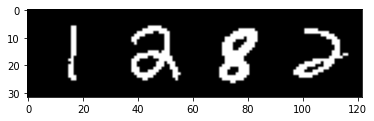

In [83]:
import matplotlib.pyplot as plt

def imshow(img):
    with torch.no_grad():
        img = torchvision.utils.make_grid(img)     
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray', vmin=0, vmax=1)
        plt.show()

imshow(images)

Network definition

In [84]:
import torch.nn as nn
import torch.nn.functional as F


class MNISTNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        #self.pool = nn.MaxPool2d(2, 2)
        self.pool1 = nn.Conv2d(6,6,2, stride=2)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.pool2 = nn.Conv2d(12,12,2, stride=2)
        self.fc1 = nn.Linear(192, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = MNISTNet()

Training

*Note*: Run training again if loss is not decreasing.

In [85]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [86]:
from matplotlib.cbook import report_memory


def mnist_classical_training():
    for epoch in range(2):  # loop over the dataset multiple times
        running_loss = 0.
        running_grad_conv1 = 0.
        for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

        # zero the parameter gradients
            optimizer.zero_grad()

        # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                inspect_grad = torch.abs(net.conv1.weight.grad).sum().numpy()

        # print statistics
            running_loss += loss.item()
            running_grad_conv1 += inspect_grad
            report_period = 200
            if i % report_period == report_period-1:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / report_period :.3f}')
                print(f'[{epoch + 1}, {i + 1:5d}] grad_conv1_changes: {running_grad_conv1 / report_period:.3f}')
                running_loss = 0.0
                running_grad_conv1 = 0.
            

    print('Finished Training')

#mnist_classical_training()

In [87]:
def predict(images):
    with torch.no_grad():
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        print('Predicted: ', ' '.join(f'{trainset.classes[predicted[j]]:5s}||'
                                        for j in range(4)))
        imshow(images)

Predicted:  6 - six|| 6 - six|| 6 - six|| 6 - six||


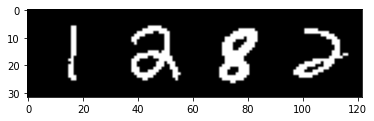

In [88]:
predict(images)

Accuracy on test set

In [89]:
testset = torchvision.datasets.MNIST(root='/home/andre/data', train=False,
                                       download=True, transform=binarize_images)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [90]:
def mnist_classical_accuracy():
    with torch.no_grad():
        correct = 0
        total = 0
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct // total} %')

# mnist_classical_accuracy()

##### Binary approach to MNIST

Network definition

In [135]:
B_MNIST = 0.25

class MNISTNetBN(nn.Module):
    def __init__(self, Q=torch.tensor([0.0125]), B=B_MNIST):
        super().__init__()
        # wrap classes to binary
        #Conv2dBN = bn(nn.Conv2d, Q)
        #LinearBN = bn(nn.Linear, Q)
        # Max pooling?
        #MaxPool2dBN = bn(nn.MaxPool2d, Q)
        
        qb = {"Q": Q, "B": B}
        self.conv1 = Conv2dBN(1, 24, 5, stride=2, **qb)
        #self.pool1 = Conv2dBN(6,6,2, stride=2)
        self.conv2 = Conv2dBN(24, 24, 5, stride=2, **qb)
        #self.pool2 = Conv2dBN(12,12,2, stride=2)
        #self.fc1 = LinearB(192, 40, **qb)
        #self.fc2 = LinearB(40, 20, **qb)
        self.fc3 = LinearB(384, 10, **qb)
        #self.fc3 = LinearB(96, 10, **qb)

    def forward(self, x):
        # x = self.pool1(self.conv1(x))
        # x = self.pool2(self.conv2(x))
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #x = self.fc1(x)
        #x = self.fc2(x)
        x = self.fc3(x)
        return x


net = MNISTNetBN()

In [136]:
torch.mean(torch.abs(net.conv1.core.weight))

tensor(0.1009, grad_fn=<MeanBackward0>)

In [137]:
torch.mean(torch.abs(net.conv2.core.weight))

tensor(0.0204, grad_fn=<MeanBackward0>)

In [138]:
#torch.mean(torch.abs(net.fc1.core.weight))

In [139]:
torch.mean(torch.abs(net.fc3.core.weight))

tensor(0.0253, grad_fn=<MeanBackward0>)

In [140]:
t = net.conv1(images)
print(t.shape)
torch.unique(t, return_counts=True)

torch.Size([4, 24, 12, 12])


(tensor([0., 1.], grad_fn=<Unique2Backward0>), tensor([12053,  1771]))

In [141]:
# with torch.no_grad():
#     net.conv1.core.weight = nn.Parameter(net.conv1.core.weight - 1.)

In [142]:
#t = net.pool1(net.conv1(images))
t = net.conv1(images)
print(t.shape)
torch.unique(t, return_counts=True)

torch.Size([4, 24, 12, 12])


(tensor([0., 1.], grad_fn=<Unique2Backward0>), tensor([12053,  1771]))

In [143]:
#t = net.pool2(net.conv2(t))
t = net.conv2(t)
torch.unique(t, return_counts=True)

(tensor([0., 1.], grad_fn=<Unique2Backward0>), tensor([1401,  135]))

In [144]:
t = torch.flatten(t, 1)
print(t.shape)

torch.Size([4, 384])


In [145]:
# t = net.fc1(t)
# print(t.shape)
# torch.unique(t, return_counts=True)

In [146]:
# t = net.fc2(t)
# print(t.shape)
# torch.unique(t, return_counts=True)

In [147]:
t = net.fc3(t)
print(t.shape)
torch.unique(t, return_counts=True)

torch.Size([4, 10])


(tensor([0., 1.], grad_fn=<Unique2Backward0>), tensor([39,  1]))

Training

In [148]:
from torch import classes

def labels_to_desired(labels):
    return torch.nn.functional.one_hot(labels, num_classes=10).float()

print(labels)
print(labels_to_desired(labels))

tensor([1, 2, 8, 2])
tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])


In [149]:
neq(labels_to_desired(labels), t)

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [150]:
def loss_bn(grad):
    with torch.no_grad():
        d = float(grad.shape[0]) * float(grad.shape[1])
        grad_flat = torch.flatten(grad)
        s = grad_flat.sum()
        return (s/d).numpy()

In [151]:
def improve_grad(grad, outputs, penalty = 1.):
    filter_not_one = (torch.sum(outputs, -1) != 1.).float()
    penalty_tensor = (1. + penalty * filter_not_one)
    return grad * torch.reshape(penalty_tensor, penalty_tensor.shape + (1,))  

In [152]:
def mnist_BN_training(lr_MNIST = 0.001, penalty=2.):
    
    lr_running = lr_MNIST 
    optimizer = torch.optim.SGD(net.parameters(), lr=lr_MNIST)
    num_lower_lr = 10

    for epoch in range(100):  # loop over the dataset multiple times
        previous_running_loss = 0.
        running_loss = 0.
        running_grad = {"conv1": [0., 0.], "conv2": [0.,0.],
                        #"pool1": [0., 0.], "pool2": [0.,0.],     
                        #"fc1": [0., 0.], 
                        "fc3": [0., 0.]}

        if num_lower_lr==0:
            break

        for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

        # zero the parameter gradients
            optimizer.zero_grad()

        # forward + backward + optimize
            outputs = net(inputs)
            one_hot_labels = labels_to_desired(labels)

            with torch.no_grad():
                grad = neq(outputs, one_hot_labels)
                grad_loss = improve_grad(grad, outputs, penalty=penalty)
            
            outputs.backward(grad_loss)
            optimizer.step()

            #if net.fc3.core.weight.grad is not None:
            #    print(torch.abs(net.fc3.core.weight.grad))

            # Debug
            with torch.no_grad():
                for layer in running_grad:
                    layer_grad = getattr(net, layer).core.weight.grad
                    num_layer_parameters = 1.
                    for d in layer_grad.shape:
                        num_layer_parameters *= d
                    inspect_grad_abs = torch.abs(layer_grad).sum().numpy()
                    inspect_grad = layer_grad.sum().numpy()
                    #(lr_MNIST/B_MNIST) *
                    running_grad[layer][0] += (1/B_MNIST) *(inspect_grad/num_layer_parameters)/batch_size
                    running_grad[layer][1] += (1/B_MNIST) *(inspect_grad_abs/num_layer_parameters)/batch_size


        # print statistics
            running_loss += loss_bn(grad_loss)     
            report_period = 2000
            if i % report_period == report_period-1:    
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / report_period :.3f}')
                for layer, l in running_grad.items():
                    l = [x * 1/float(report_period) for x in l]
                    print(f'[{epoch + 1}, {i + 1:5d}] grad_{layer}_changes: {l[0] :.4f}, {l[1] :.4f}')
                
                #reset
                if running_loss>previous_running_loss + 0.001 and previous_running_loss!=0.:
                    lr_running = 0.5 * lr_running
                    optimizer = torch.optim.SGD(net.parameters(), lr=lr_running)
                    num_lower_lr -= 1
                    if num_lower_lr == 0:
                        break
                    print("Lowered learning rate")
                    
                previous_running_loss = running_loss
                running_loss = 0.
                for layer in running_grad:
                    running_grad[layer] = [0.,0.]

    print('Finished Training')

mnist_BN_training()

[1,  2000] loss: 0.204
[1,  2000] grad_conv1_changes: -0.0124, 0.0842
[1,  2000] grad_conv2_changes: -0.0005, 0.1381
[1,  2000] grad_fc3_changes: 0.0006, 0.2793
[1,  4000] loss: 0.178
[1,  4000] grad_conv1_changes: -0.0001, 0.0770
[1,  4000] grad_conv2_changes: 0.0003, 0.1217
[1,  4000] grad_fc3_changes: 0.0002, 0.2337
[1,  6000] loss: 0.173
[1,  6000] grad_conv1_changes: -0.0001, 0.0799
[1,  6000] grad_conv2_changes: 0.0001, 0.1174
[1,  6000] grad_fc3_changes: -0.0002, 0.2289
[1,  8000] loss: 0.177
[1,  8000] grad_conv1_changes: -0.0000, 0.0757
[1,  8000] grad_conv2_changes: -0.0000, 0.1178
[1,  8000] grad_fc3_changes: 0.0000, 0.2308
Lowered learning rate
[1, 10000] loss: 0.158
[1, 10000] grad_conv1_changes: -0.0005, 0.0565
[1, 10000] grad_conv2_changes: -0.0000, 0.0998
[1, 10000] grad_fc3_changes: -0.0007, 0.2172
[1, 12000] loss: 0.152
[1, 12000] grad_conv1_changes: 0.0002, 0.0439
[1, 12000] grad_conv2_changes: -0.0000, 0.0882
[1, 12000] grad_fc3_changes: -0.0002, 0.2103
[1, 14000] l

Accuracy on the test set

In [153]:
def num_correct(t, labels):
    filter_only_one = torch.sum(t, -1)==1
    filter_one_and_correct = torch.argmax(t[filter_only_one], -1) == torch.argmax(labels_to_desired(labels)[filter_only_one], -1)
    correct = filter_one_and_correct.sum().item()
    false = filter_only_one.sum().item() - correct
    return correct, false

num_correct(t, labels)

(0, 1)

In [155]:
def mnist_bn_statistics():
    total_stats = {k: 0 for k in range(10)}
    stat = {k: 0 for k in range(11)}
    one_and_correct = {"correct": 0, "false": 0}
    missed_by_no_prediction  = {k: 0 for k in range(10)}
    one_detailed = {k: {"correct": 0, "false": 0} for k in range(10)}
    confusion_matrix = np.zeros((10, 10), dtype=np.int16)
    
    with torch.no_grad():
        correct = 0
        total = 0
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            for k in stat:
                filter_k = torch.sum(outputs, -1)==k
                stat[k] += (filter_k).sum().item()
                
                if k==0:
                    for label in missed_by_no_prediction:
                        missed_by_no_prediction[label] += (labels[filter_k]==label).sum().item()

                if k==1:
                    for prediction in one_detailed:
                        outputs_one = outputs[filter_k]
                        labels_one = labels[filter_k]
                        filter_prediction = torch.argmax(outputs_one, -1) == prediction
                        labels_prediction = labels_one[filter_prediction]

                        num_results_label = num_correct(outputs_one[filter_prediction], labels_prediction)
                        one_detailed[label]["correct"] += num_results_label[0]
                        one_detailed[label]["false"] += num_results_label[1]
                        
                        for label in range(10):
                            confusion_matrix[prediction, label] += (labels_prediction==label).sum().item()



            for k in total_stats:     
                total_stats[k] += (labels == k).sum().item()

            num_results = num_correct(outputs, labels)
            one_and_correct["correct"] += num_results[0]
            one_and_correct["false"] += num_results[1]

    print("Total counts for the labels 0,1,..,9: {}\n".format(total_stats))
    print("Number of predictions returned per input (1 is best, 0 means no prediction): {}\n".format(stat)) 
    print("Analysis when only one prediction is returned: {}\n".format(one_and_correct))
    print(f'Accuracy on only one prediction: {one_and_correct["correct"]/(stat[1]):.1f}')
    print("Analysis when only one prediction is returned per label: {}\n".format(one_detailed))
    print("For which labels 0,1,..,9 did the model not predict: {}\n".format(missed_by_no_prediction))
    print("Confusion matrix")
    print(confusion_matrix)

mnist_bn_statistics()

Total counts for the labels 0,1,..,9: {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}

Number of predictions returned per input (1 is best, 0 means no prediction): {0: 1922, 1: 6736, 2: 1253, 3: 87, 4: 2, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}

Analysis when only one prediction is returned: {'correct': 6202, 'false': 534}

Accuracy on only one prediction: 0.9207244655581948
Analysis when only one prediction is returned per label: {0: {'correct': 0, 'false': 0}, 1: {'correct': 0, 'false': 0}, 2: {'correct': 0, 'false': 0}, 3: {'correct': 0, 'false': 0}, 4: {'correct': 0, 'false': 0}, 5: {'correct': 0, 'false': 0}, 6: {'correct': 0, 'false': 0}, 7: {'correct': 0, 'false': 0}, 8: {'correct': 0, 'false': 0}, 9: {'correct': 6202, 'false': 534}}

For which labels 0,1,..,9 did the model not predict: {0: 108, 1: 139, 2: 164, 3: 220, 4: 192, 5: 247, 6: 178, 7: 186, 8: 213, 9: 275}

Confusion matrix
[[747   0  11   5   1  10   6   3   7   3]
 [  0 930   4   4 